# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [1]:
dataDir = "/home/ababil/BUET/AV/csv"
# dataDir = "C:/Users/Zenbook325E/Downloads/csv"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2/lab"

In [2]:
exec(open('init_notebook.py').read())

current working dir/home/ababil/BUET/AV/May 2023/AV/src


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.TrajectoryADECalculator import TrajectoryADECalculator
from tti_dataset_tools.ColMapper import ColMapper

In [5]:
sceneId = 10
date = "2022-12-22"
fps=5
minYDisplacement = 5
maxXDisplacement = 6
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

In [6]:
visualizer = TrajectoryVisualizer()
adeCalculator = TrajectoryADECalculator()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity',
        xAccCol='sceneXAcceleration',
        yAccCol='sceneYAcceleration',
        speedCol='speed',
        accelerationCol='acceleration',
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    minAcceleration = 0.0,
    maxAcceleration = 2.0,   
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
transformer.deriveAcceleration(pedDf)
# plt.boxplot(pedDf['displacementY'])
# plt.show()
# plt.boxplot(pedDf['speed'])
# plt.show()
# plt.boxplot(pedDf['acceleration'])
# plt.show()

In [7]:
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)

# visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)

southIds = []
for pedId in allPedIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
    # print(trackMeta['verticalDirection'])
    if trackMeta['verticalDirection'] == "SOUTH":
        southIds.append(pedId)
        # print(trackMeta["uniqueTrackId"])
        X, Y = transformer.rotate(trackDf)
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
len(cleanPedDf)


using min Y displacement (5)


3989

In [8]:

startingDf = cleanPedDf[cleanPedDf["displacementY"] < 1].copy()
startingDf.head(10)

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY
0,18,751,18023,10,5.0,0.633506,2.406819,-0.124725,1.197404,-0.200707,-0.049552,1.203882,0.000000,0.000000,0.206733,-0.000000,-0.000000
1,18,756,18023,10,5.0,0.653314,2.163065,-0.099043,1.218770,-0.128407,-0.106831,1.222788,0.019809,0.243754,0.167037,-0.019809,0.243754
2,18,761,18023,10,5.0,0.674600,1.919279,-0.106426,1.218930,0.036911,-0.000799,1.223567,0.041094,0.487540,0.036920,-0.041094,0.487540
3,18,766,18023,10,5.0,0.701232,1.674626,-0.133163,1.223264,0.133686,-0.021670,1.230490,0.067726,0.732193,0.135431,-0.067726,0.732193
4,18,771,18023,10,5.0,0.728331,1.426538,-0.135494,1.240441,0.011656,-0.085887,1.247819,0.094825,0.980281,0.086675,-0.094825,0.980281
50,18,2696,18053,10,5.0,0.857354,2.336601,0.045148,1.059391,1.010939,-0.402157,1.060352,0.223848,0.070218,1.087993,-0.000000,-0.000000
51,18,2701,18053,10,5.0,0.885137,2.110236,-0.138919,1.131822,0.920336,-0.362158,1.140316,0.251632,0.296582,0.989028,-0.027784,0.226364
52,18,2706,18053,10,5.0,0.925876,1.857610,-0.203694,1.263128,0.323873,-0.656531,1.279447,0.292370,0.549208,0.732071,-0.068523,0.478990
53,18,2711,18053,10,5.0,0.949118,1.586989,-0.116209,1.353108,-0.437424,-0.449896,1.358089,0.315612,0.819830,0.627492,-0.091764,0.749612
75,18,4180,18069,10,5.0,0.535340,2.368113,-0.457393,1.472568,0.234670,-0.294592,1.541968,0.098166,0.038705,0.376636,-0.000000,-0.000000


In [9]:
# plt.boxplot(startingDf["speed"])

In [10]:
# get the pedestrians who started at almost 0 speed.
# get pedestrians who started at almost the median speed.
medianStartingSpeed = startingDf["speed"].median()
medianStartingVelocityDf = startingDf[abs(startingDf["speed"] - medianStartingSpeed) < 0.005].copy()
medianStartingVelocityPedIds = list(medianStartingVelocityDf["uniqueTrackId"].unique())
# medianStartingVelocityPedIds

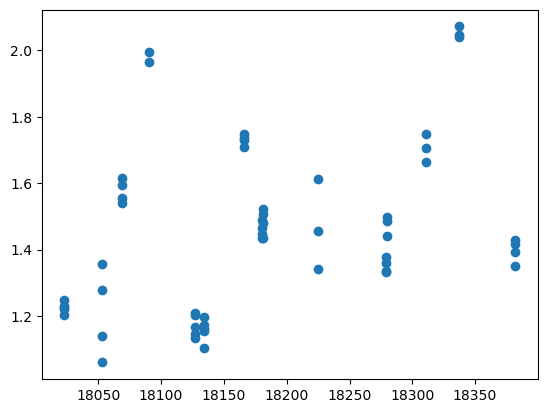

In [11]:
allPedIds
startingEditedDf = startingDf[startingDf["uniqueTrackId"] < 18500].copy()
plt.scatter(startingEditedDf["uniqueTrackId"], startingEditedDf["speed"])
# plt.show()

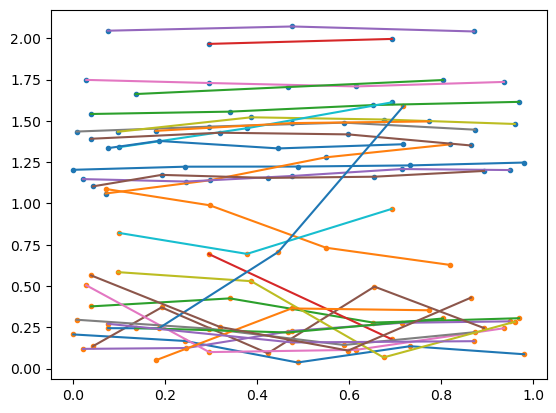

In [12]:

plt.scatter(startingEditedDf["displacementY"], startingEditedDf["speed"], marker = ".")


        
uniqueTrackId_collection = {} 

for pedId in allPedIds:
    uniqueTrackId_collection[pedId] = startingEditedDf[startingEditedDf["uniqueTrackId"] == pedId].copy()
    plt.plot(uniqueTrackId_collection[pedId]["displacementY"], uniqueTrackId_collection[pedId]["speed"])
# plt.show()
plt.scatter(startingEditedDf["displacementY"], startingEditedDf["acceleration"], marker = ".")
for pedId in allPedIds:
    uniqueTrackId_collection[pedId] = startingEditedDf[startingEditedDf["uniqueTrackId"] == pedId].copy()
    plt.plot(uniqueTrackId_collection[pedId]["displacementY"], uniqueTrackId_collection[pedId]["acceleration"])
# plt.show()

In [29]:
adeCalculator.calculate(startingDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

Track Ids length: 208
ADE : 0.09463137001193975
Track Ids Sampled length: 10
27488 -0.0
27488 0.0160470629575932
27488 -0.014418288309502602
27488 -0.0611279428376159
21115 -0.0
21115 -0.1414420454419151
21115 -0.2810750763888539
21115 -0.4215211443661227
21115 -0.5576966010757802
24364 -0.0
24364 -0.04965206475645578
24364 -0.09889155323870408
28522 -0.0
28522 -0.11241851931185487
28522 -0.22261516474866788
28522 -0.3311056117777246
21518 -0.0
21518 0.017022089283333708
21518 0.023104140549159213
21518 0.019469052925578545
29211 -0.0
29211 -0.13284317882930785
29211 -0.25686472040063335
24039 -0.0
24039 -0.03749418515427169
24039 -0.08146845895846219
18225 -0.0
18225 -0.08527528787815997
18225 -0.15651716589778875
19071 -0.0
19071 -0.14810560188484523
19071 -0.29815434663855034
19071 -0.42239523732733275
20362 -0.0
20362 -0.11868872280567527
20362 -0.23084658709435907
20362 -0.33948166429396515
ADE Sampled: 0.11737658533455686


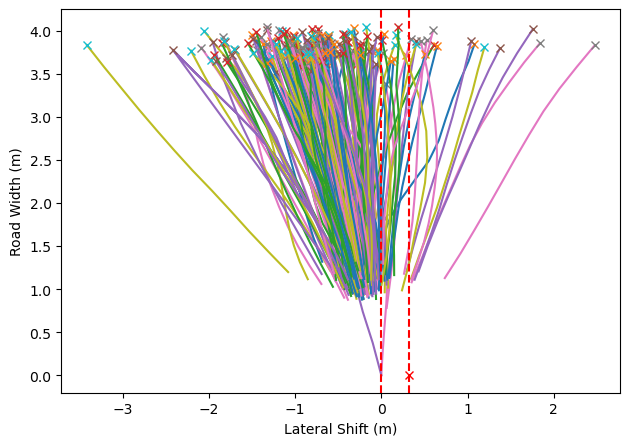

In [23]:
midDf = cleanPedDf[(cleanPedDf["displacementY"] >= 1) & (cleanPedDf["displacementY"] < 4)].copy()
visualizer.show(midDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dbfcba8580>,
 'caps': [<matplotlib.lines.Line2D at 0x1dbfcba8af0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dbfcba8430>],
 'medians': [<matplotlib.lines.Line2D at 0x1dbfcbb5070>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dbfcbb5310>],
 'means': []}

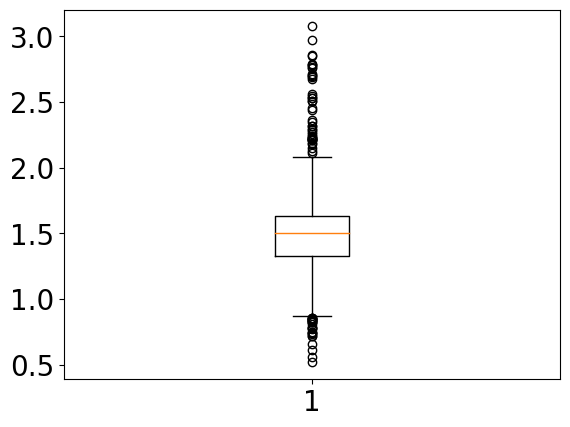

In [15]:
plt.boxplot(midDf["speed"])

ADE : 0.16371960034188088
ADE Sampled: 0.1574387861889448


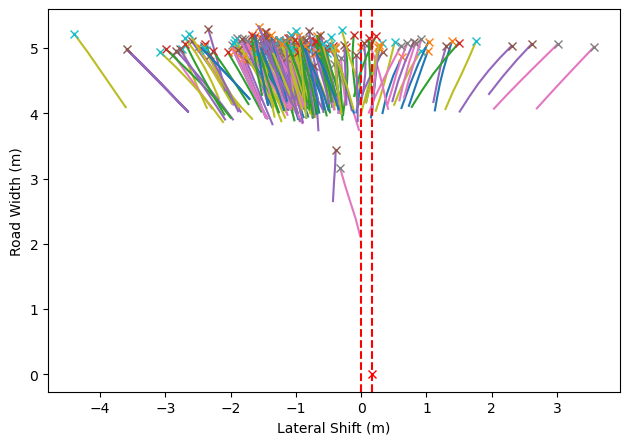

In [15]:
endDf = cleanPedDf[(cleanPedDf["displacementY"] >= 4)].copy()
visualizer.show(endDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

{'whiskers': [<matplotlib.lines.Line2D at 0x1dbfe2ee760>,
 'caps': [<matplotlib.lines.Line2D at 0x1dbfe2eeaf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1dbfe2b2f40>],
 'medians': [<matplotlib.lines.Line2D at 0x1dbfe2eefd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1dbfe2ee430>],
 'means': []}

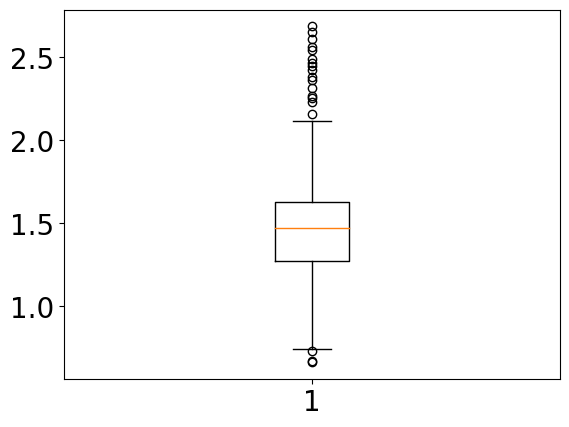

In [17]:
plt.boxplot(endDf["speed"])

<AxesSubplot: xlabel='speed', ylabel='Count'>

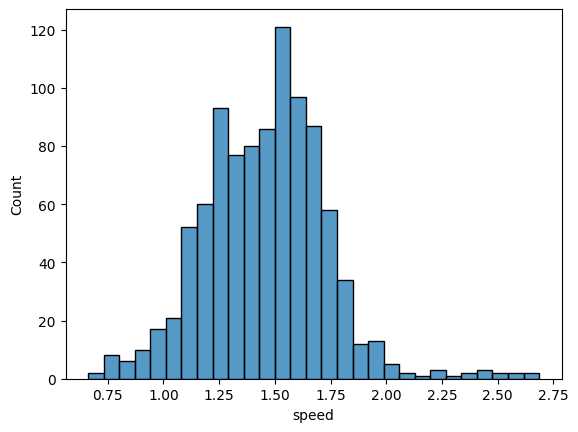

In [18]:
sns.histplot(endDf["speed"])